# BigQuery

### About Google BigQuery

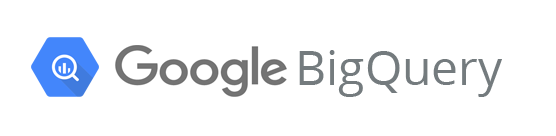

* You get 1TB of queries free per month
* No credit card needed to sign up
* You can get $300 of free credit when signing up for the first time

### Setting Up Google BigQuery

* https://bigquery.cloud.google.com
* sign in with google/ gmail account
* Create Project
* (this seems to hang a bit)
    * go back to original URL and select "enable on existing project" and choose your project.
* "Go to project settings"
* "Service Accounts"
* "Create Service Account"
* "Create"
* "Role": "BigQuery User"
* "Create key", "JSON", Download file
* Store .json file in home folder or similar
* update `BIGQUERY_JSON_KEY` variable below to reflect its location, and make sure it's readable by the notebook

### Sample Projects of Interest

* [reddit_posts](https://bigquery.cloud.google.com/dataset/fh-bigquery:reddit_posts)
* [reddit_comments](https://bigquery.cloud.google.com/dataset/fh-bigquery:reddit_comments)
* [stackoverflow](https://bigquery.cloud.google.com/dataset/fh-bigquery:stackoverflow_archive)
* [githubarchive](https://bigquery.cloud.google.com/table/githubarchive:month.201809?tab=preview)
* [gdelt](https://bigquery.cloud.google.com/table/gdelt-bq:full.events)

### Sync Queries

The below code performs synchronous queries with a fixed timeout.

For bigger dataset or queries that take longer, the proper way is to store results to bigquery storage asynchronously and to fetch the data from there once the query is completed.

In [4]:
import os

from dotenv import load_dotenv
load_dotenv()

JSON_KEY = os.environ['BIGQUERY_JSON_KEY']

In [5]:
import json
import os

from bigquery import get_client  # BigQuery-Python
from bigquery.errors import BigQueryTimeoutException
import pandas as pd

pd.options.display.max_colwidth = 280

class TimeoutException(Exception):
    pass
 
bqp_client = get_client(json_key_file=JSON_KEY, readonly=False)


def perform_query(query, timeout=500):
    """ run a query on google bigquery and return result set as dataframe """
    try:
        job_id, _results = bqp_client.query(query, timeout=timeout)
        return pd.DataFrame(bqp_client.get_query_rows(job_id))
    except BigQueryTimeoutException:
        raise TimeoutException()

### Aside: Async Queries

Below an pseudo-code snippet to demo asynchronous queries for larger or longer-running queries:

```python
    from google.cloud import storage
  
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucketname)
    blob = bucket.get_blob(csvname)
    if blob:
        blob.delete()

    job = bqp_client.write_to_table(query
                                    dataset=datasetname,
                                    table=tablename
                                    # allow_large_results
                                   )
    try:
        job_resource = bqp_client.wait_for_job(job, timeout=TIMEOUT)
    except bigquery.errors.BigQueryTimeoutException:
        pass
    
    job = bqp_client.export_data_to_uris(destination_uris=['gs://%s/%s' % (bucketname, csvname)],
                                         dataset=datasetname,
                                         table=tablename,
                                         #job=jobname,
                                         compression=Compression.GZIP,
                                         destination_format=DestinationFormat.CSV)
    try:
        job_resource = bqp_client.wait_for_job(job, timeout=TIMEOUT)
    except bigquery.errors.BigQueryTimeoutException:
        pass
        
    blob = bucket.get_blob(csvname)
    blob.download_to_file(fhandle)
```

## Reddit Comments

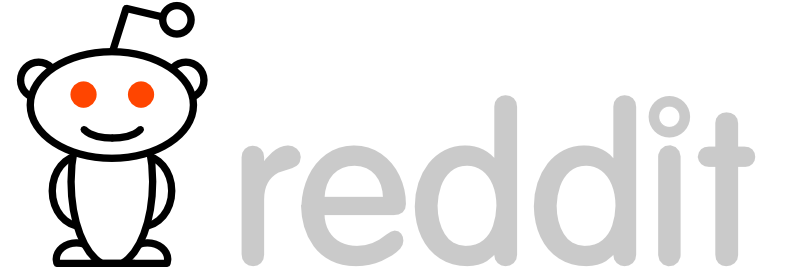

Use Cases:

* extract related videos
* extract [cryptocurrencies sentiments](https://github.com/fluquid/cryptocurrency) ;)
* etc.

[Live Query](https://bigquery.cloud.google.com/results/asdf-167312:US.bquijob_1dc61ccc_1651f0db2c5)

In [6]:
reddit_query = """
SELECT body, link_id
FROM [fh-bigquery:reddit_comments.2018_07]
WHERE subreddit_id = 't5_2qh1e'
AND (body CONTAINS 'youtu.be' or body CONTAINS 'youtube.com')
ORDER BY link_id;
"""
# this query ignores limit requests, so restrain yourself ;)

reddit_results = perform_query(reddit_query)
reddit_results.head(10)

,body,link_id
0,"And 7 years later in 1969, Neil Armstrong became the first man on the moon. This is 49 years ago a came across this fitting video tribute to this historical occasion at https://youtu.be/Vc-_xBC5sYk",t3_7wptw2
1,I dunno... [Mr. Marvin Gaye...](https://www.youtube.com/watch?v=QRvVzaQ6i8A) killed it,t3_7ymeia
2,"How does it compare to this one? https://www.youtube.com/watch?v=4cRlqE3D3RQ\nHe guesses kinda similar to the east, but doesn't focus on a particular language.",t3_8551k1
3,"Compared to this guy, he does.\nhttps://youtu.be/tIdIqbv7SPo?t=43s",t3_86ak1o
4,dangerous for democracy \n\n[Review](http://www.youtube.com/c/BestProductReviewCom),t3_88ll08
5,Hey hey! Just wanted to let you know Episode 3 is now posted! https://www.youtube.com/watch?v=7T8--yhYyjw&amp;t=2s,t3_89vpne
6,"Hey, thanks so much! Weird to hear about the audio... seems good on our end but we will totally check it out. Also, we just released Ep 3 so feel free to watch it here! https://www.youtube.com/watch?v=7T8--yhYyjw&amp;t=2s",t3_89vpne
7,"&gt; https://youtu.be/YF8I-PotoK8\n\nShit, I forgot about this video. Dirty, dirty, DIRTY. Yet the heads turning make it so good. :P\n",t3_8lnm0o
8,[Oh these killers](https://www.youtube.com/watch?v=VBkV-2YgF8I&amp;feature=youtu.be),t3_8mox83
9,Is this a good method? https://www.youtube.com/watch?v=LT_dFRnmdGs,t3_8o1n0l


## Github Archive

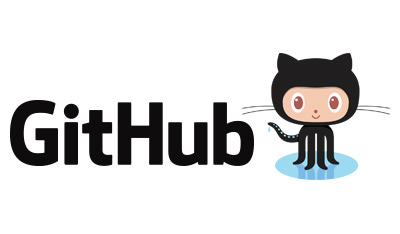

* https://www.gharchive.org/

Use Cases:

* find related, similar projects using Association Rules/ Basket Analysis of stars
* analyze project health and activity
* perform competitive intelligence, find main committers on projects
* find similar users to follow

[Live Query](https://bigquery.cloud.google.com/results/asdf-167312:US.bquijob_66a061fa_1651e735e63)


### Github Repos

* https://bigquery.cloud.google.com/dataset/bigquery-public-data:github_repos
* contents from 2.9m public, open source repositories

In [7]:
github_query = """
SELECT
  actor.login,
  actor.id,
  repo.name,
  repo.id
FROM [githubarchive:day.20180927]
WHERE
  type = "WatchEvent"
LIMIT 50;
"""

github_results = perform_query(github_query)
github_results.head(10)

,actor_id,actor_login,repo_id,repo_name
0,2242,softprops,131996323,yoshuawuyts/github_auth
1,2882,nikolay,135516270,ibuildthecloud/k3s
2,2882,nikolay,150135162,ciganche/EndzinSrc
3,3443,mikeymicrophone,75598601,Toinane/colorpicker
4,3443,mikeymicrophone,85040759,onmyway133/FinderGo
5,3443,mikeymicrophone,42574339,sindresorhus/caprine
6,5132,cbueno,147816240,sohamkamani/detective
7,9525,ashmckenzie,135516270,ibuildthecloud/k3s
8,14523,MadRabbit,115078176,chris-pearce/backpack.css
9,14547,evaryont,77224514,mattock/automatic-cloud-backup


### My Star History

Let's find out what repos I starred in September.

In [8]:
github_query = """
SELECT
  actor.login,
  actor.id,
  repo.name,
  repo.id
FROM [githubarchive:month.201809]
WHERE
  type = "WatchEvent" AND actor.login = 'codinguncut'
ORDER BY created_at DESC
LIMIT 50;
"""

github_results = perform_query(github_query)
github_results.head(10)

,actor_id,actor_login,repo_id,repo_name
0,2112583,codinguncut,69837138,pywren/pywren
1,2112583,codinguncut,15857755,DenisCarriere/geocoder
2,2112583,codinguncut,114515852,marl/crepe
3,2112583,codinguncut,147001703,cgarciae/pypeln
4,2112583,codinguncut,615096,edgewall/trac
5,2112583,codinguncut,1127737,pn2200/g3data
6,2112583,codinguncut,24586308,cfenollosa/os-tutorial
7,2112583,codinguncut,12616670,ajinabraham/OWASP-Xenotix-XSS-Exploit-Framework
8,2112583,codinguncut,941687,subgraph/Vega
9,2112583,codinguncut,36817565,zaproxy/zaproxy


## GDELT

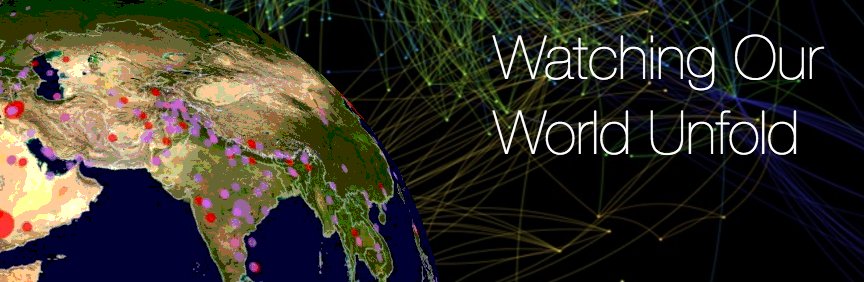

Monitors the world's broadcast, print, and web news from nearly every corner of every country in over 100 languages and identifies the people, locations, organizations, counts, themes, sources, emotions, counts, quotes, images and events.

Use Cases:

* use world events for financial modelling
* track corporate news events for due diligence
* use to train NER and sentiment analysis

[Live Query](https://bigquery.cloud.google.com/results/asdf-167312:US.bquijob_6fbdd131_15f06ba0085)

In [9]:
gdelt_query = """
SELECT SQLDATE, Actor1Code, Actor1Name, Actor2Code, Actor2Name, AvgTone, SOURCEURL
FROM [gdelt-bq:gdeltv2.events]
WHERE MonthYear == 201809 AND Actor1Code == 'IRLGOV'
LIMIT 1000
"""

gdelt_results = perform_query(gdelt_query)
gdelt_results.head(20)

,Actor1Code,Actor1Name,Actor2Code,Actor2Name,AvgTone,SOURCEURL,SQLDATE
0,IRLGOV,IRELAND,None,None,-1.522248,https://www.irishmirror.ie/news/irish-news/politics/ireland-presidential-campaign-debate-rte-13320221,20180927
1,IRLGOV,IRELAND,GOV,GOVERNMENT,7.428571,https://www.con-telegraph.ie/news/roundup/articles/2018/09/27/4162626-mayo-tidy-towns-committees-to-share-51000-grant/,20180927
2,IRLGOV,IRELAND,None,None,3.847478,https://www.agriland.ie/farming-news/creed-deems-current-suckler-supports-appropriate/,20180927
3,IRLGOV,IRELAND,EDU,STUDENT,-1.121076,https://www.breakingnews.ie/ireland/four-candidates-trade-blows-in-first-presidential-election-debate-871942.html,20180927
4,IRLGOV,IRISH,IRL,DUBLIN,-2.735411,https://www.sonline.hu/egyperces/lekesett-gepe-utan-futott-egy-ferfi-a-dublini-repuloteren-1225256/,20180927
5,IRLGOV,IRELAND,None,None,1.927195,https://dublingazette.com/news/south-dublin-news/new-chapter-for-stillorgan-library-with-e1-5m-funding/,20180927
6,IRLGOV,IRISH,REL,SAINT,5.381944,https://www.vermontbiz.com/event/september/irish-ambassador-speak-saint-michael%e2%80%99s-about-yeats-oct-1,20180927
7,IRLGOV,IRELAND,IRL,IRISH,-2.071006,https://www.lincolnshirelive.co.uk/news/local-news/parents-who-fled-child-ireland-2045392,20180926
8,IRLGOV,IRELAND,IRL,IRISH,-0.224719,http://opticxllyaroused.com/2018/09/27/ramaphosa-unveils-statue-of-madiba-at-united-nations.html,20180927
9,IRLGOV,IRELAND,USA,UNITED STATES,-6.830601,https://www.independent.ie/world-news/north-america/brett-kavanaugh-groped-girls-at-parties-as-a-teen-says-third-accuser-37359505.html,20180927
